## import Modules

In [1]:
import os
import cv2
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read images

In [2]:
lick_folder = 'lick'
void_folder = 'void'

lick_image_list = os.listdir(lick_folder)
void_image_list = os.listdir(void_folder)
lick_nsample = len(lick_image_list)
void_nsample = len(void_image_list)
# attention: positive and negative sample number balance!

n_total_sample = lick_nsample + void_nsample
X = np.empty(shape = (n_total_sample, 300, 300, 3)) # resize image into 300x300
count = 0
for image_filename in lick_image_list:
	image_fullname = os.path.join(lick_folder,image_filename)
	img = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
	X[count,:,:,:]=img
	count += 1

for image_filename in void_image_list:
	image_fullname = os.path.join(void_folder,image_filename)
	img = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
	X[count,:,:,:]=img
	count += 1

y = np.concatenate((np.ones(shape = (lick_nsample, 1)),np.zeros(shape = (void_nsample, 1))))

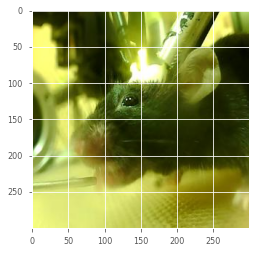

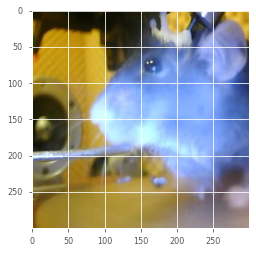

In [28]:
idx = random.randint(0,lick_nsample)
image_fullname = os.path.join(lick_folder,lick_image_list[idx])
img_lick_example = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB)
plt.imshow(img_lick_example)
plt.show()

idx = random.randint(0,void_nsample)
image_fullname = os.path.join(void_folder,void_image_list[idx])
img_void_example = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB)
plt.imshow(img_void_example)

## Train Test set splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## Conv Model

In [4]:
def LickModel(input_shape):
    """
    Implementation of the LickModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]    

    Returns:
    model -- a Model() instance
    """
    
    # input place holder
    X_input = Input(input_shape)     
    # zero-padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # CONV -- BN -- RELU
    X = Conv2D(32, (9,9), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool')(X)
    
    # CONV -- BN -- RELU
    X = Conv2D(64, (7,7), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool1')(X)
    
        
    # CONV -- BN -- RELU
    X = Conv2D(64, (5,5), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    
    # CONV -- BN -- RELU
    X = Conv2D(128, (3,3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    
    # FLATEN and FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name = 'fc')(X)
    
    # CREATE MODEL
    model = Model(inputs=X_input, outputs=X, name='LickModel')    
    return model

## Fit and evaluate the model

In [5]:
lickModel = LickModel(X_train.shape[1:])
lickModel.summary()

Model: "LickModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 306, 306, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 298, 298, 32)      7808      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 298, 298, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 149, 149, 32)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 143, 143, 64)      10

In [6]:
lickModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
lickModel.fit(x = X_train, y = y_train, epochs = 30, batch_size = 16, verbose = 2) # accuracy=0.9961 val_accuracy=0.9884

Epoch 1/30
16/16 - 9s - loss: 3.2525 - accuracy: 0.5078
Epoch 2/30
16/16 - 1s - loss: 1.0929 - accuracy: 0.6484
Epoch 3/30
16/16 - 1s - loss: 0.3574 - accuracy: 0.8516
Epoch 4/30
16/16 - 1s - loss: 0.3158 - accuracy: 0.8828
Epoch 5/30
16/16 - 1s - loss: 0.2707 - accuracy: 0.8789
Epoch 6/30
16/16 - 1s - loss: 0.2638 - accuracy: 0.8828
Epoch 7/30
16/16 - 1s - loss: 0.2335 - accuracy: 0.9141
Epoch 8/30
16/16 - 1s - loss: 0.2286 - accuracy: 0.9414
Epoch 9/30
16/16 - 1s - loss: 0.1454 - accuracy: 0.9414
Epoch 10/30
16/16 - 1s - loss: 0.2146 - accuracy: 0.9219
Epoch 11/30
16/16 - 1s - loss: 0.1202 - accuracy: 0.9531
Epoch 12/30
16/16 - 1s - loss: 0.1163 - accuracy: 0.9453
Epoch 13/30
16/16 - 1s - loss: 0.0684 - accuracy: 0.9805
Epoch 14/30
16/16 - 1s - loss: 0.1134 - accuracy: 0.9570
Epoch 15/30
16/16 - 1s - loss: 0.0498 - accuracy: 0.9883
Epoch 16/30
16/16 - 1s - loss: 0.0848 - accuracy: 0.9609
Epoch 17/30
16/16 - 1s - loss: 0.0820 - accuracy: 0.9805
Epoch 18/30
16/16 - 1s - loss: 0.0470 - 

KeyboardInterrupt: 

## Early stopping to prevent overfitting

In [73]:
# Or Early stopping to prevent overfitting
callback = EarlyStopping(monitor='loss', patience=4)
lickModel.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), callbacks=[callback], epochs = 30, batch_size = 16, verbose = 2)

Epoch 1/30
16/16 - 2s - loss: 0.0339 - accuracy: 0.9844 - val_loss: 0.0279 - val_accuracy: 0.9884
Epoch 2/30
16/16 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9767
Epoch 3/30
16/16 - 1s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 4/30
16/16 - 1s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9884
Epoch 5/30
16/16 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9767
Epoch 6/30
16/16 - 1s - loss: 0.0112 - accuracy: 0.9961 - val_loss: 0.0577 - val_accuracy: 0.9884
Epoch 7/30
16/16 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9884
Epoch 8/30
16/16 - 1s - loss: 0.0123 - accuracy: 0.9922 - val_loss: 0.1312 - val_accuracy: 0.9767
Epoch 9/30
16/16 - 1s - loss: 0.0673 - accuracy: 0.9844 - val_loss: 0.0575 - val_accuracy: 0.9884
Epoch 10/30
16/16 - 1s - loss: 0.0168 - accuracy: 0.9922 - val_loss: 0.2797 - val_accuracy: 0.9651


## Prediction and evaluation

In [7]:
preds = lickModel.evaluate(x = X_test, y = y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 [==============================] - 2s 351ms/step - loss: 0.0529 - accuracy: 0.9884
Loss = 0.05293278396129608
Test Accuracy = 0.9883720874786377


In [ ]:
y_pred = lickModel.predict(X_test)
y_pred_class = y_pred>0.5
classification_report(y_test, y_pred_class)

AUC: 0.9983695652173914


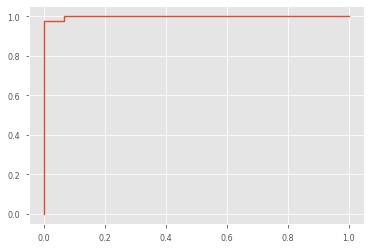

In [15]:
y_pred_class = y_pred>0.5
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
print('AUC:',auc(fpr, tpr))